# A. Last Name: Kaushik.
# B. Date: 14th Aug, 2017.
# C. This solution is reflects a good mix of concepts of EDA, feature engineering, Model selection and parameter tuning to derive significant Out-of-Bag validation score.
# D. Estimated AUC: 0.91
# E. Paramter Tuning using Out-of-Bag validation resuts. 

## Importing Required Libraries

In [1]:

import pandas as pd
import numpy as np

import seaborn as sns

from sklearn import model_selection, preprocessing, ensemble
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier

from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

%matplotlib inline

## Reading the data

In [2]:
train = pd.read_csv("train0.csv")
test = pd.read_csv("test0.csv")

In [3]:
#Glimpse of the dataset
train.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0
2,54,0.004129,laptop,M,0,83439,1,3,7,0
3,16,0.005117,Android,F,0,30110,2,3,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,0


In [4]:
#Correcting the daat types

train['device_type'] = train['device_type'].astype('category')
train['gender'] = train['gender'].astype('category')

test['device_type'] = test['device_type'].astype('category')
test['gender'] = test['gender'].astype('category')


In [5]:
train.dtypes

age                              int64
cost_of_ad                     float64
device_type                   category
gender                        category
in_initial_launch_location       int64
income                           int64
n_drivers                        int64
n_vehicles                       int64
prior_ins_tenure                 int64
outcome                          int64
dtype: object

## EDA

In [6]:
#Ouutcome Class Distribution in percentage

(train.outcome.value_counts()/len(train.outcome))*100


0    90.18
1     9.82
Name: outcome, dtype: float64

#### Class Skew is high and Approaches like:

#### 1. Undersampling.
#### 2. Oversampling.
#### 3. Using Error Functions like F-Score, logloss for training. 

#### Can be used. But since the evaluation metric in this test is auc, we'll use auc as well on the orignam dataset simulate the performance on test set through cross-validation

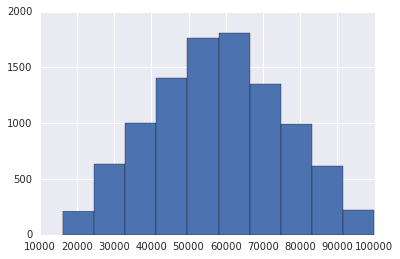

In [7]:
train.income.hist()

#### Generally the income distributions have long tails. This looks preety normally distributed. The data must have been treated beforehand.

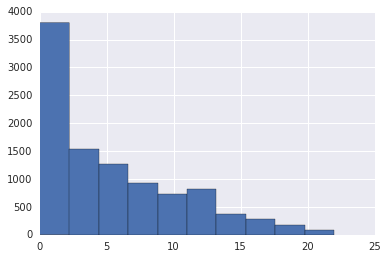

In [8]:
train.prior_ins_tenure.hist()


### The distribution has heavy positive sckew. We can reduce the scew in this case by taking log(k+n) transformation.

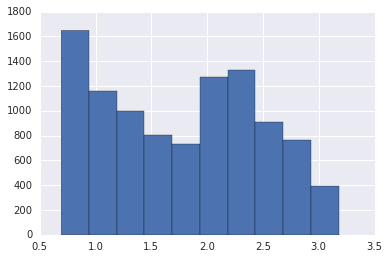

In [9]:
np.log(2+train.prior_ins_tenure).hist()

In [10]:
train.prior_ins_tenure = np.log(2+train.prior_ins_tenure)
test.prior_ins_tenure = np.log(2+test.prior_ins_tenure)


In [11]:
pd.crosstab(train.outcome, train.device_type, rownames=['Outcome'], colnames=['Device_Type'], margins=True)

Device_Type,Android,desktop,iPhone,laptop,other,All
Outcome,,,,,,
0,1719,1685,1803,1901,1910,9018
1,304,347,165,90,76,982
All,2023,2032,1968,1991,1986,10000


### laptop and other devices have significantly lower ad click proportion compared to other platforms

In [12]:
pd.crosstab(train.outcome, train.gender, rownames=['Outcome'], colnames=['gender'], margins=True)

gender,F,M,All
Outcome,,,
0,4677,4081,8758
1,293,680,973
All,4970,4761,9731


### There are more number of females but males have more than double ad clicks than females.

In [13]:
pd.crosstab(train.outcome, train.in_initial_launch_location, rownames=['Outcome'], colnames=['in_initial_launch_location'], margins=True)

in_initial_launch_location,0,1,All
Outcome,,,
0,4705,4313,9018
1,320,662,982
All,5025,4975,10000


### Also, being in in initial launch location doubles the chances of clicking on an ad.

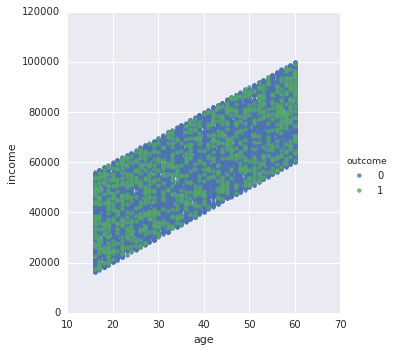

In [14]:
sns.lmplot(x='age', y='income', data=train,
           fit_reg=False, # No regression line
           hue='outcome')   # Color by evolution stage


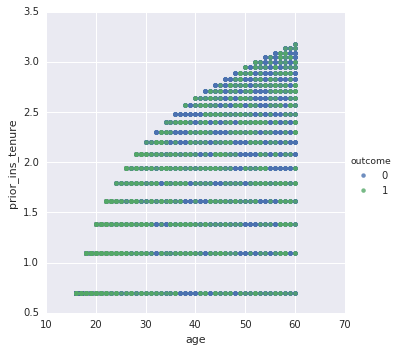

In [15]:
sns.lmplot(x='age', y='prior_ins_tenure', data=train,
           fit_reg=False, 
           hue='outcome') 

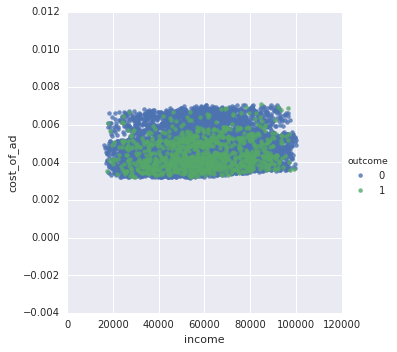

In [16]:
sns.lmplot(x='income', y='cost_of_ad', data=train,
           fit_reg=False, 
           hue='outcome') 


### Observatios:

### 1. All these plots conforms our hypothisis that the data has been processed as it the plots look very indifferent.

### 2. By observing the color dimension, its clear that the outcome exhibits non-linear relationship with majority of the preictors. Therefore, tree based models are suited for this dataset. I'll use Random Forest model for this problem which leverages the bagging  concept (growing multiple decesion trees with sample of features on bootstrap samples of the orignal data) to overcome the high variance issue observed in single decision trees.

## Feature Engineering

### Performing one hot encoding for device_type and gender features

In [17]:
oh = pd.get_dummies(train[['device_type', 'gender']])

train.drop(['device_type', 'gender'], axis=1, inplace=True)

train = pd.concat([train, oh], axis = 1)

In [18]:
oh2 = pd.get_dummies(test[['device_type', 'gender']])

test.drop(['device_type', 'gender'], axis=1, inplace=True)

test = pd.concat([test, oh2], axis = 1)

## Creating a feature for income to age ratio

In [19]:
train['income_by_age'] = train.income/ train.age
test['income_by_age'] = test.income/ test.age

### Creating a feature for no. of drivers per vehicle

In [20]:
train['drivers_per_vehicle'] = train.n_vehicles/train.n_drivers
test['drivers_per_vehicle'] = test.n_vehicles/test.n_drivers

## Data Prepration

In [21]:

train_y = train.outcome

train.drop('outcome', axis=1, inplace=True)

train_X = train



In [22]:
test_X = test

In [23]:
print(train_X.shape)
print(train_y.shape)

print(test_X.shape)

(10000, 16)
(10000,)
(10000, 16)


## Modelling

### Findding the optimal paramteres on out of sample error.

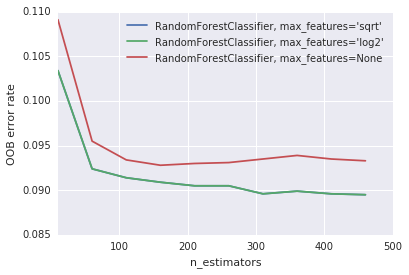

In [24]:

RANDOM_STATE = 0

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=False, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=False, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=False, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators, 50):
        clf.set_params(n_estimators=i)
        clf.fit(train_X, train_y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()


### Fitting the Random Forest model

In [25]:

model = RandomForestClassifier(n_estimators=300, criterion='gini', max_features='log2',
                               bootstrap=True, oob_score=True, n_jobs=16,
                               random_state=RANDOM_STATE)


model.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=16,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

# Feature Importance

In [26]:

imp_df_rf = pd.DataFrame(
    {'Predictors': train_X.columns,
     'Importance': model.feature_importances_.tolist()
    })

imp_df_rf = imp_df_rf.sort(['Importance'], ascending=False)

imp_df_rf


,Importance,Predictors
1,0.176602,cost_of_ad
3,0.166930,income
14,0.164967,income_by_age
0,0.132809,age
6,0.093298,prior_ins_tenure
15,0.051307,drivers_per_vehicle
2,0.046438,in_initial_launch_location
5,0.034792,n_vehicles
8,0.024634,device_type_desktop
7,0.021213,device_type_Android


## Expected Accuracy on test set

### Let's check an estimate of the accuracy of our model on test set by looking at the model's out of bag accuracy. 

In [27]:
model.oob_score_

0.91020000000000001

# Predicting for test

### Predicting Labels

In [28]:
preds = model.predict(test_X)

In [29]:
pd.value_counts(pd.Series(preds))

0    9615
1     385
dtype: int64

### Predicting probabilities which can be used for leading propensity based advertising campaigns. Also, it can halp in evaluation like observing the aur-roc cure, etc

In [30]:
pred_prob = model.predict_proba(test_X)

## Outputing First 5 preictions

In [31]:
preds[:5]

array([0, 0, 0, 0, 0])

## Outputing First 5 preiction probabilities | Of being 1 and 0 respectively

In [32]:
pred_prob[:5]

array([[ 0.98666667,  0.01333333],
       [ 0.92666667,  0.07333333],
       [ 0.87333333,  0.12666667],
       [ 0.99333333,  0.00666667],
       [ 0.99      ,  0.01      ]])